This notebook shows how you can use jax within the context of a custom class to perform mathematical operations. Some examples as to why / use cases are shown via performance benchmarking at the bottom of this notebook.

In [2]:
import jax
import jax.numpy as jnp
from jax.scipy.integrate import trapezoid
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import time

In [18]:
class CustomFunc:
  """
  A custom function class that will be used to derivate, integrate, and plot
  passed in arrrays of inputs and ouputs.

  function: When instantiating a CustomFunc you must specify a function to the
            object. For example, you could use a lambda function such as:

            lambda x: x**2 + 10,

            or you could specify simple operations:

            jnp.cos
  """

  def __init__(self, function):
    self._f = jax.jit(function) # just-in-time compile (jit) the passed in func
    self._df = jax.jit(jax.grad(self._f)) # jit the derivative of the func
    # You could add more derivatives here or other operations

  # Do not need to decorate evaluate / derivative since they have been
  # jitted in the init.
  def evaluate(self, x: float):
    """ Returns the function evaluation of a passed in value """
    return self._f(x)

  def derivative(self, x: float):
    """ Returns the derivative evaluation of a passed in value """
    return self._df(x)

  # When specifying a jit-ted function in a class, you must specify that
  # static_argnums=(0,). This tells jax that "self" is a static variable.
  # Therefore, you can not change the values of "self" throughout the
  # process!
  @partial(jax.jit, static_argnums=(0,))
  def integral(self, x: np.array):
    """ Returns the integral evaluation of a passed in range """
    return trapezoid(self._f(x), x)

  def plot(self, x, y):
    """ Simply plots the passed in x and y values """
    plt.plot(x, y)
    plt.show()


Below are two code examples showing how one would use this CustomFunc class. A benefit to jit-ting these methods is that the code within is then compiled, and the functions run-time will be likely be much more efficient. This is most important when you have long loops of operations, as we will see in the final cell.

Evaluation of cosine at x=pi    | -1.0
Derivate of cosine at x=pi      | 8.742277657347586e-08
Integral of cosine from 0 to pi | -1.1920928955078125e-07


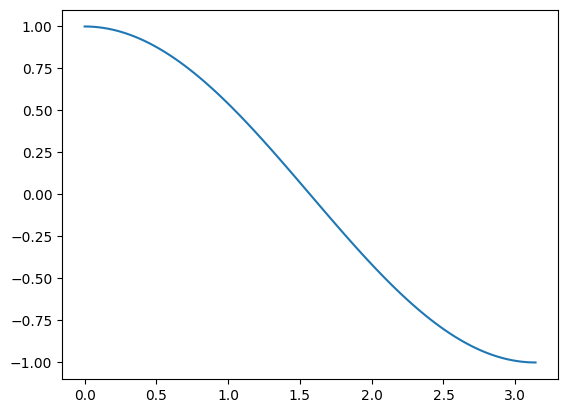

In [19]:
x = jnp.linspace(0, np.pi, 100)
cosine = CustomFunc(jnp.cos)
print(f'Evaluation of cosine at x=pi    | {cosine.evaluate(np.pi)}')
print(f'Derivate of cosine at x=pi      | {cosine.derivative(np.pi)}')
print(f'Integral of cosine from 0 to pi | {cosine.integral(x)}')
cosine.plot(x, cosine.evaluate(x))

Evaluation of x^2 + 2x + 1 at x=5     | 36.0
Derivate of x^2 + 2x + 1 at x=5       | 12.0
Integral of x^2 + 2x + 1 from 0 to 5  | 71.66879272460938


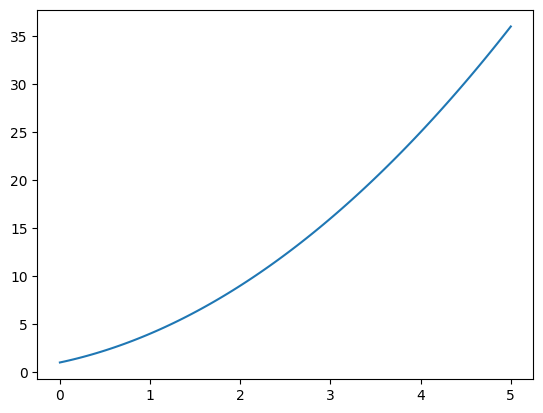

In [20]:
custom_func = lambda x: x**2 + 2*x + 1
x = jnp.linspace(0, 5, 100)
cf = CustomFunc(custom_func)
print(f'Evaluation of x^2 + 2x + 1 at x=5     | {cf.evaluate(5.)}')
print(f'Derivate of x^2 + 2x + 1 at x=5       | {cf.derivative(5.)}')
print(f'Integral of x^2 + 2x + 1 from 0 to 5  | {cf.integral(x)}')
cf.plot(x, cf.evaluate(x))

In [21]:
from scipy.integrate import trapezoid as tzoid

class NoJitFunc:
  """
  A non-jitted function class that will be used to derivate, integrate, and plot
  passed in arrrays of inputs and ouputs. It will be used to compare to the
  jitted CustomFunc class.
  """

  def __init__(self, function):
    self._f = function

  def evaluate(self, x: float):
    return self._f(x)

  def derivative(self, x: float):
    # NOTE: I do not want to implement a numerical method to show this, but you
    #       overall this would be slower without the use of auto-dif from
    #       packages like jax
    return NotImplementedError

  def integral(self, x: np.array):
    return tzoid(self._f(x), x)

  def plot(self, x, y):
    plt.plot(x, y)
    plt.show()


In [22]:
f = lambda x: (2 * x**5) - (3 * x**4) + (7 * x**3) - (2 * x**2) + (5*x) - 1
jit_func = CustomFunc(f)
no_jit_func = NoJitFunc(f)

# Grab some eval times (~un-efficiently~)
ts1 = time.perf_counter()
jit_func.evaluate(5.123)
ts2 = time.perf_counter()
no_jit_func.evaluate(5.123)
ts3 = time.perf_counter()
jit_func.integral(np.linspace(0, 10, 1000))
ts4 = time.perf_counter()
no_jit_func.integral(np.linspace(0, 10, 1000))
ts5 = time.perf_counter()

# Print the times
t_jit = ts2 - ts1
t_no_jit = ts3 - ts2
t_int_jit = ts4 - ts3
t_int_no_jit = ts5 - ts4

print(f'Jitted f(x=5.123)                | {jit_func.evaluate(5.)} | time (s) | {t_jit}')
print(f'Non-jitted f(x=5)                | {no_jit_func.evaluate(5.)} | time (s) | {t_no_jit}')
print(f'Jitted integral from 0 to 10     | {jit_func.integral(np.linspace(0, 10, 1000))} | time (s) | {t_int_jit}')
print(f'Non-jitted integral from 0 to 10 | {no_jit_func.integral(np.linspace(0, 10, 1000))} | time (s) | {t_int_no_jit}')

Jitted f(x=5.123)                | 5224.0 | time (s) | 0.04939674799993554
Non-jitted f(x=5)                | 5224.0 | time (s) | 0.00014946000010240823
Jitted integral from 0 to 10     | 290407.4375 | time (s) | 0.08785697700000128
Non-jitted integral from 0 to 10 | 290407.41866976384 | time (s) | 0.0005946799999492214


Wait a minute, it wasn't faster!

Generally, you won't see the performance benefits of jit until you run loops and loops of iterations!

In [32]:
ts1 = time.time()
# We need to evaluate that function from 0 -> 10 for 1000 intervals.
# JAX really shines when we have these long batches of data. If you
# were to just use say x=5, then jax would be pointless (and probably slower)
x = jnp.linspace(0, 10, 1000)
N = 10000
jit_func.evaluate(1) # Warmup the jit
for i in range(N):
  jit_func.evaluate(x)
ts2 = time.time()
for i in range(N):
  no_jit_func.evaluate(x)
ts3 = time.time()

t_jit = ts2 - ts1
t_no_jit = ts3 - ts2

print(f'Jitted f(x=5.123) for {N} loops     | time (s) | {t_jit}')
print(f'Non-jitted f(x=5.123) for {N} loops | time (s) | {t_no_jit}')
print(f'Jitted evaluation is {t_no_jit / t_jit:.0f}x faster')

Jitted f(x=5.123) for 10000 loops     | time (s) | 0.18333125114440918
Non-jitted f(x=5.123) for 10000 loops | time (s) | 13.332019805908203
Jitted evaluation is 73x faster
